In [52]:
import cytoflow as flow
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import glob
import numpy as np
import pandas as pd
import matplotlib.colors as colors


darks=['#3a80b0', '#ff7200', '#984ea3', '#7fc97f',  '#e261b0']
pastels=['#b3cde3','#fed9a6','#decbe4','#ccebc5',  '#f4cae4']
superdarks=['#1f5a82', '#ee4e00', '#771e85', '#41ab5d', '#cf3092']

plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20

In [53]:
def import_fcs_files(path, sample_list):
    files=glob.glob(path)
#     print(len(files))   
    
    samples=[]
    for f in files: 
        well=f[-7:-4]
        conditions={'well':well}
        
        check=sample_list.loc[sample_list['well']==well, sample_list.columns[1]].reset_index(drop=True)[0]
        if check !='blank':
            condition=sample_list.loc[sample_list['well']==well, 'construct'].reset_index(drop=True)[0]
            conditions['sample']=condition
            
            sample=flow.Tube(file=f, conditions=conditions)
            samples.append(sample)
    
    cond_type={'well': 'category',
               'sample': 'category'}
    
    expout=flow.ImportOp(tubes=samples, conditions=cond_type).apply()
    return(expout)

In [54]:
# import data for fig 3i
#raw data not uploaded to github, but available
#code to calculate medians is included -> median values are included in csv file

samples1=pd.read_csv('flow_fig3i_CRISPR_rep1/plate_1/sample_list.csv')
samples2=pd.read_csv('flow_fig3i_CRISPR_rep2/plate_1/sample_list.csv')
samples3=pd.read_csv('flow_fig3i_CRISPR_rep3/plate_1/sample_list.csv')
samples3

,well,construct
0,A01,506
1,A02,blank
2,A03,A
3,A04,blank
4,A05,C
5,A06,blank
6,A07,G
7,A08,blank
8,B01,755_506
9,B02,blank


In [55]:
exp1=import_fcs_files('flow_fig3i_CRISPR_rep1/plate_1/*.fcs', samples1)
exp2=import_fcs_files('flow_fig3i_CRISPR_rep2/plate_1/*.fcs', samples2)
exp3=import_fcs_files('flow_fig3i_CRISPR_rep3/plate_1/*.fcs', samples3)


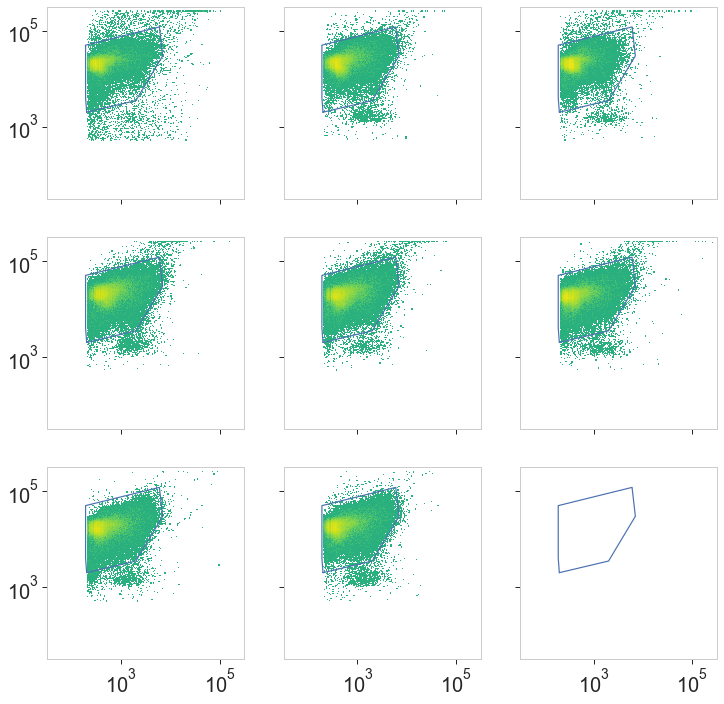

In [56]:
#example gating for data (fig 3i)

xbins=10**np.linspace(1.5,5.5,1000)
ybins=10**np.linspace(1.5,5.5,1000)
    
test1=exp1.data.loc[exp1.data['well']=='A01']
test2=exp1.data.loc[exp1.data['well']=='B07']
test3=exp1.data.loc[exp1.data['well']=='C01']

test4=exp2.data.loc[exp2.data['well']=='B01']
test5=exp2.data.loc[exp2.data['well']=='C03']
test6=exp2.data.loc[exp2.data['well']=='A05']

test7=exp3.data.loc[exp3.data['well']=='A03']
test8=exp3.data.loc[exp3.data['well']=='B03']
test9=exp3.data.loc[exp3.data['well']=='C07']


pt1=[200, 2000]
pt2=[2000, 3500]
pt3=[7000, 30000]
pt4=[6000, 120000]
pt5=[190, 50000]
pt6=[190, 4000]

fig, [[ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9]]=plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 12))

for test, ax in zip([test1, test2, test3, test4, test5, test6, test7, test8, test9],
                   [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]):
    counts, _, _=np.histogram2d(test['FSC-H'], test['SSC-H'], bins=(xbins, ybins))
    ax.pcolormesh(xbins, ybins, counts.T, norm=colors.LogNorm(.0001, vmax=200), cmap='viridis')
    ax.plot([pt1[0], pt2[0], pt3[0], pt4[0], pt5[0], pt6[0], pt1[0]], [pt1[1], pt2[1], pt3[1], pt4[1], pt5[1], pt6[1], pt1[1]], '-')
    

ax1.set_xscale('log')
ax1.set_yscale('log')


plt.show()
plt.close()

In [57]:
# apply gate

gate=flow.PolygonOp(name='cells', 
                   xchannel='FSC-H', 
                   ychannel='SSC-H', 
                   xscale='log',
                   yscale='log')
gate.vertices=[pt1, pt2, pt3, pt4, pt5, pt6]

exp1=gate.apply(exp1)
exp2=gate.apply(exp2)
exp3=gate.apply(exp3)
exp3.data.head()


,FITC-A,FSC-A,FSC-H,FSC-W,PE-Texas Red-A,Pacific Blue-A,SSC-A,SSC-H,SSC-W,Time,sample,well,cells
0,19897.919922,34.020000,445.0,5010.190430,38.25,98.579994,23141.759766,18905.0,80223.132812,54.500000,506,A01,True
1,41307.839844,1398.869995,1290.0,71066.929688,270.75,-231.079987,34272.960938,19751.0,113721.468750,54.599998,506,A01,True
2,12016.319336,-194.399994,312.0,0.000000,34.50,319.059998,15713.279297,14865.0,69275.851562,54.599998,506,A01,True
3,25728.958984,159.570007,589.0,17754.804688,91.50,-48.759998,28464.000000,22240.0,83876.648438,54.700001,506,A01,True
4,20279.039062,983.340027,1288.0,50034.300781,-131.25,284.079987,38330.878906,32609.0,77035.562500,54.700001,506,A01,True


In [58]:
# calculate medians

med1=exp1.data.loc[exp1.data['cells']==True].groupby(by='sample')['FITC-A'].median().reset_index()
med2=exp2.data.loc[exp2.data['cells']==True].groupby(by='sample')['FITC-A'].median().reset_index()
med3=exp3.data.loc[exp3.data['cells']==True].groupby(by='sample')['FITC-A'].median().reset_index()


med1=med1.rename(columns={'FITC-A':'med1'})
med2=med2.rename(columns={'FITC-A':'med2'})
med3=med3.rename(columns={'FITC-A':'med3'})
meds=pd.merge(med1, med2, on='sample')
meds=pd.merge(meds, med3, on='sample')
meds['med']=meds[['med1', 'med2', 'med3']].mean(axis=1)
meds

#755 corresponds to B subtilis SEN2C2-# (755_506 is SEN2C2-T)

,sample,med1,med2,med3,med
0,C,15310.080078,15708.479492,16407.359375,15808.639648
1,755A,5567.040039,5670.719727,5633.279785,5623.679850
2,A,14284.799805,16439.039062,15535.679688,15419.839518
3,755_506,7122.239746,7800.959961,7973.759766,7632.319824
4,506,15520.319336,15893.759766,15707.519531,15707.199544
5,G,15991.679688,17306.878906,16921.919922,16740.159505
6,755G,9110.399414,10560.959961,11016.959961,10229.439779
7,755C,1343.039917,1249.919922,1416.959961,1336.639933


In [60]:
meds.to_csv('medians_fig3i.csv')

In [61]:
meds=pd.read_csv('medians_fig3i.csv')

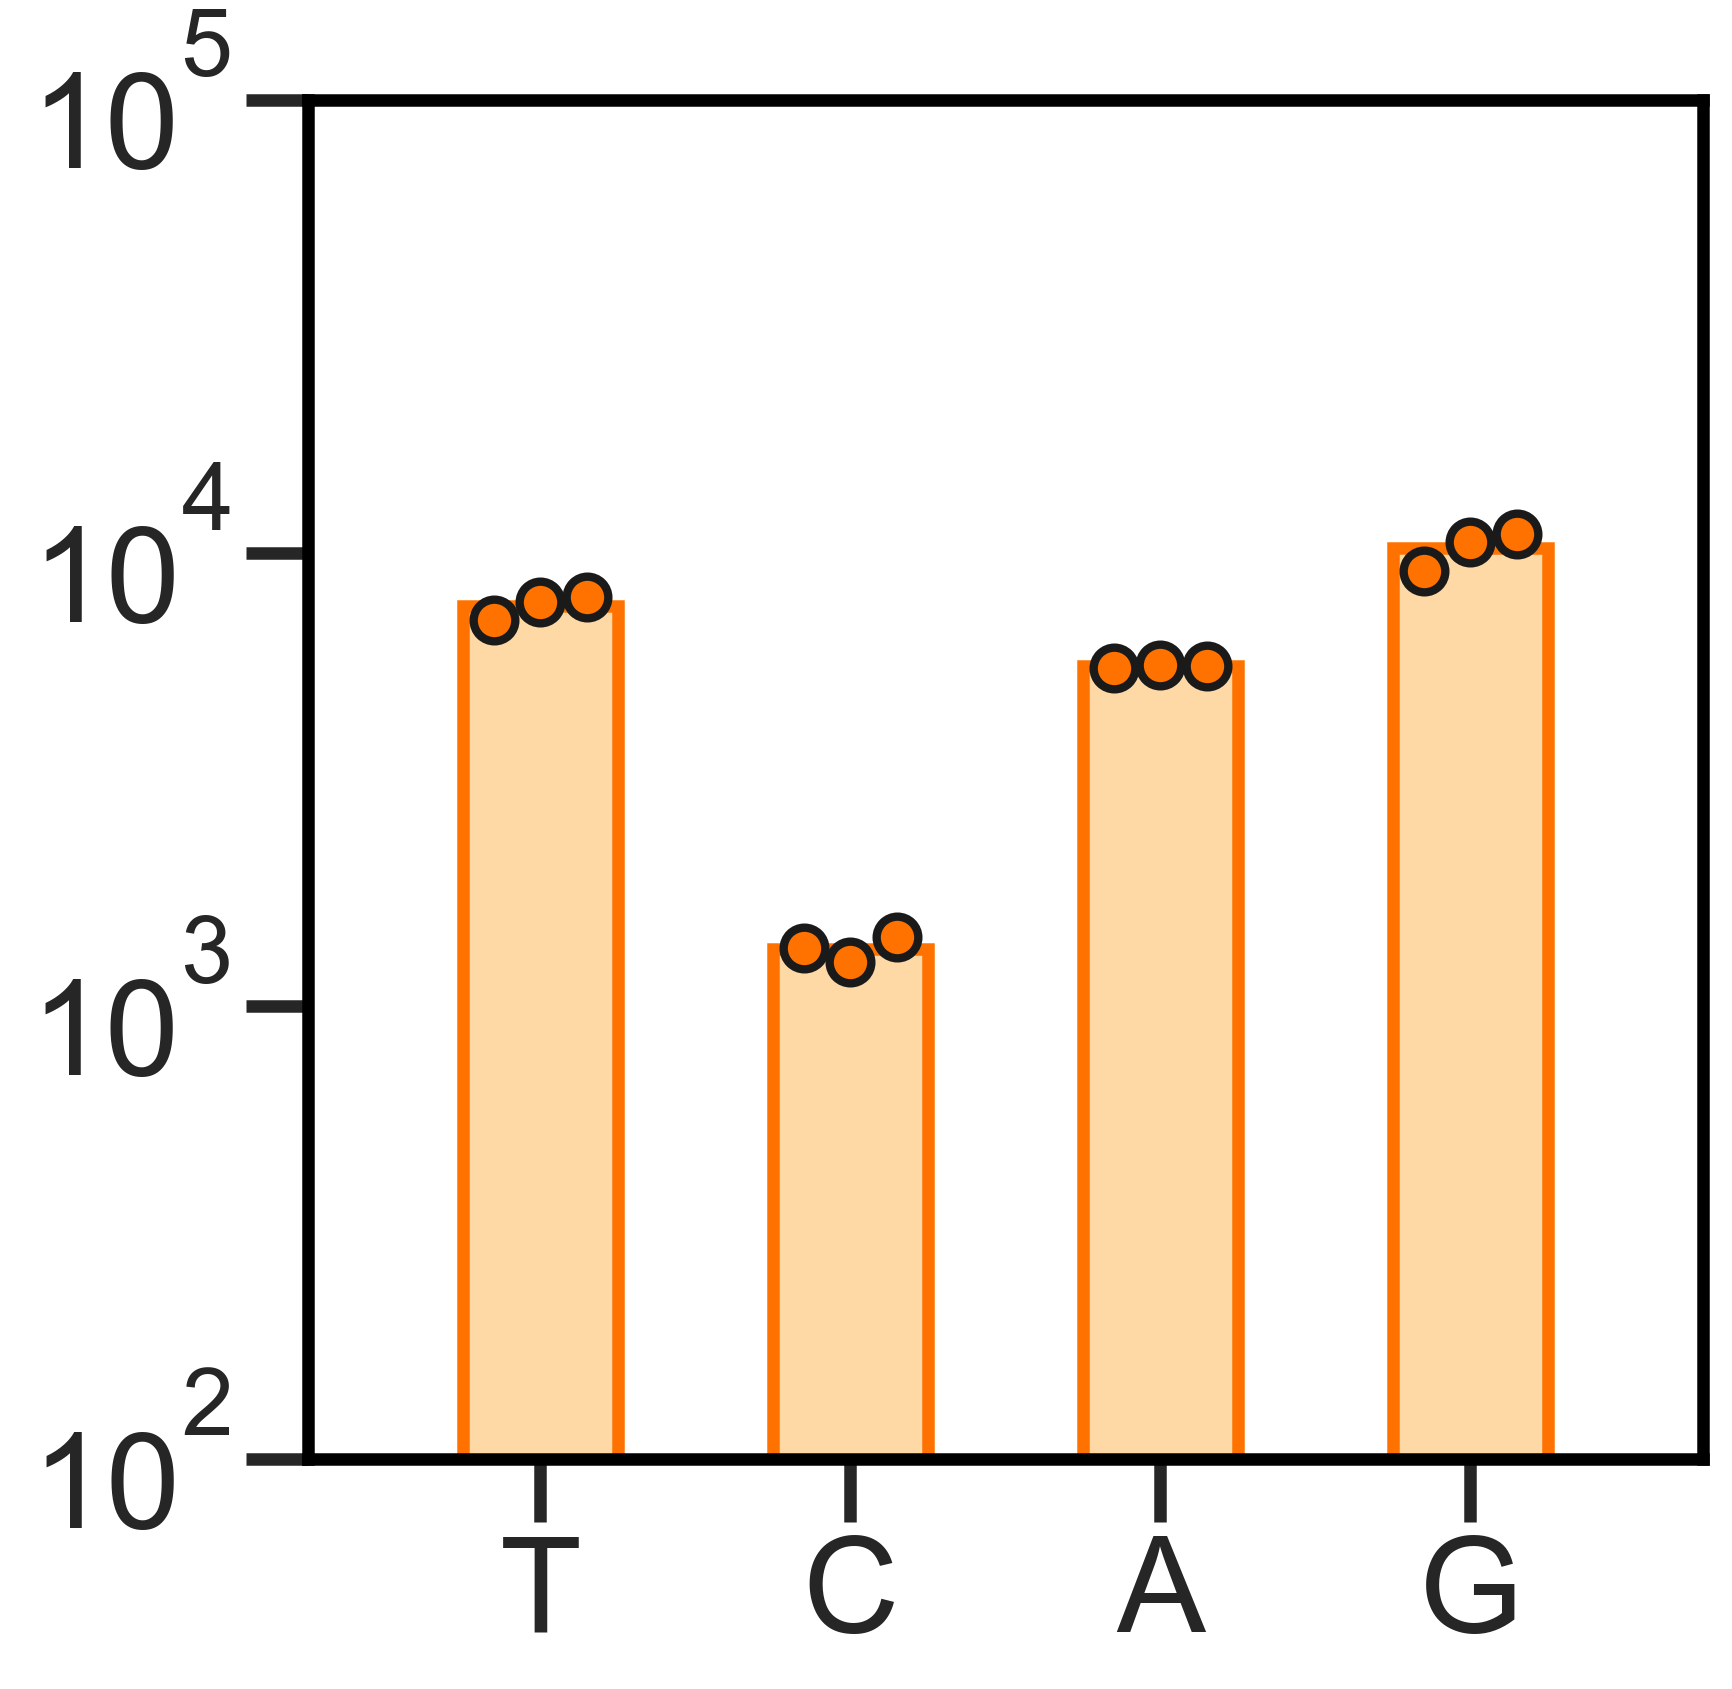

In [62]:
#generates fig 3i


fig, ax=plt.subplots(figsize=(6,6), dpi=300)
w=.5
ms=10
lw=3
fc='#FED9A6'
ec='#FF7200'
d=.15
mew=2

ax.bar(0, meds.loc[meds['sample']=='755_506', 'med'], width=w, color=fc, ec=ec, lw=lw)
ax.bar(1, meds.loc[meds['sample']=='755C', 'med'], width=w, color=fc, ec=ec, lw=lw)
ax.bar(2, meds.loc[meds['sample']=='755A', 'med'], width=w, color=fc, ec=ec, lw=lw)
ax.bar(3, meds.loc[meds['sample']=='755G', 'med'], width=w, color=fc, ec=ec, lw=lw)

ax.plot(0-d, meds.loc[meds['sample']=='755_506', 'med1'], 'o', color=ec, ms=ms, mec='k', mew=mew)
ax.plot(1-d, meds.loc[meds['sample']=='755C', 'med1'], 'o', color=ec, ms=ms, mec='k', mew=mew)
ax.plot(2-d, meds.loc[meds['sample']=='755A', 'med1'], 'o', color=ec, ms=ms, mec='k', mew=mew)
ax.plot(3-d, meds.loc[meds['sample']=='755G', 'med1'], 'o', color=ec, ms=ms, mec='k', mew=mew)

ax.plot(0, meds.loc[meds['sample']=='755_506', 'med2'], 'o', color=ec, ms=ms, mec='k', mew=mew)
ax.plot(1, meds.loc[meds['sample']=='755C', 'med2'], 'o', color=ec, ms=ms, mec='k', mew=mew)
ax.plot(2, meds.loc[meds['sample']=='755A', 'med2'], 'o', color=ec, ms=ms, mec='k', mew=mew)
ax.plot(3, meds.loc[meds['sample']=='755G', 'med2'], 'o', color=ec, ms=ms, mec='k', mew=mew)

ax.plot(0+d, meds.loc[meds['sample']=='755_506', 'med3'], 'o', color=ec, ms=ms, mec='k', mew=mew)
ax.plot(1+d, meds.loc[meds['sample']=='755C', 'med3'], 'o', color=ec, ms=ms, mec='k', mew=mew)
ax.plot(2+d, meds.loc[meds['sample']=='755A', 'med3'], 'o', color=ec, ms=ms, mec='k', mew=mew)
ax.plot(3+d, meds.loc[meds['sample']=='755G', 'med3'], 'o', color=ec, ms=ms, mec='k', mew=mew)

ax.set_xticks([0, 1, 2, 3])
ax.set_xlim(-.75, 3.75)
ax.set_xticklabels(['T', 'C', 'A', 'G'])

ax.set_yscale('log')
ax.set_yticks([1e2, 1e3, 1e4, 1e5])

ax.grid(False)


ax.tick_params(which='major', direction='out', length=15, width=lw)
ax.tick_params(which='minor', direction='out', length=0, width=1)
ax.tick_params(axis='both', which='major', labelsize=32)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(lw)
    ax.spines[axis].set_color('black')


plt.show()
plt.tight_layout()
# fig.savefig('fig3i.pdf', bbox_inches='tight')
plt.close()

In [63]:
#code below this is for extended data figure

In [64]:
# import data for extended data figure

def import_fcs_files(path, sample_list, names_in):
    files=glob.glob(path)
    print(len(files))   
    
    samples=[]
    for f in files: 
        well=f[-7:-4]
#         print(well)
        construct=sample_list[sample_list['well']==well]['construct'].reset_index(drop=True)[0]
        sensor=sample_list[sample_list['well']==well]['sensor'].reset_index(drop=True)[0]
        DNA=sample_list[sample_list['well']==well]['DNA'].reset_index(drop=True)[0]
#         print(construct)
#         print(sensor)
        if sensor in names_in:
            #print(name)
            sample=flow.Tube(file=f, conditions={'construct':construct,
                                                'sensor':sensor,
                                                'DNA':DNA})
            samples.append(sample) 
    expout=flow.ImportOp(tubes=samples, conditions={'construct':'category',
                                                   'sensor':'category',
                                                   'DNA':'category'}).apply()
    return(expout)

samples1=pd.read_csv('flow_CRISPR_ED_rep1/sample_list.csv')
samples2=pd.read_csv('flow_CRISPR_ED_rep2/plate_1/sample_list.csv')
samples3=pd.read_csv('flow_CRISPR_ED_rep3/plate_1/sample_list.csv')

names1=[name for name in samples1['sensor'].unique() if name!='blank']
names2=[name for name in samples2['sensor'].unique() if name!='blank']
names3=[name for name in samples3['sensor'].unique() if name!='blank']

exp1=import_fcs_files('flow_CRISPR_ED_rep1/*.fcs', samples1, names1)
exp2=import_fcs_files('flow_CRISPR_ED_rep2/plate_1/*.fcs', samples2, names2)
exp3=import_fcs_files('flow_CRISPR_ED_rep3/plate_1/*.fcs', samples3, names3)


14
20
20


In [65]:
# apply gate


pt1=[200, 2000]
pt2=[2000, 3500]
pt3=[7000, 30000]
pt4=[6000, 120000]
pt5=[190, 50000]
pt6=[190, 4000]


gate=flow.PolygonOp(name='cells', 
                   xchannel='FSC-H', 
                   ychannel='SSC-H', 
                   xscale='log',
                   yscale='log')
gate.vertices=[pt1, pt2, pt3, pt4, pt5, pt6]

exp1=gate.apply(exp1)
exp2=gate.apply(exp2)
exp3=gate.apply(exp3)
exp3.data.head()


,DNA,FITC-A,FSC-A,FSC-H,FSC-W,PE-Texas Red-A,Pacific Blue-A,SSC-A,SSC-H,SSC-W,Time,construct,sensor,cells
0,-,53.690002,-426.579987,282.0,0.000000,-393.899994,663.599976,4771.130371,5342.0,58532.531250,55.599998,-,506,True
1,-,-11.830000,-65.449997,291.0,0.000000,-127.139992,530.250000,32458.791016,26371.0,80665.101562,60.299999,-,506,True
2,-,54.600002,18822.650391,14593.0,84531.023438,-285.479980,-916.649963,3452.540039,3325.0,68049.820312,72.500000,-,506,False
3,-,-66.430000,291.059998,482.0,39574.500000,39.779999,-47.249996,1360.450073,1378.0,64701.351562,73.099998,-,506,False
4,-,58.240002,36.959999,297.0,8155.590820,240.239990,-1143.449951,4200.560059,3821.0,72046.039062,74.699997,-,506,True


In [72]:
med1=exp1.data.loc[exp1.data['cells']==True].groupby(by=['construct', 'sensor', 'DNA'])['FITC-A'].median().reset_index()
med2=exp2.data.loc[exp2.data['cells']==True].groupby(by=['construct', 'sensor', 'DNA'])['FITC-A'].median().reset_index()
med3=exp3.data.loc[exp3.data['cells']==True].groupby(by=['construct', 'sensor', 'DNA'])['FITC-A'].median().reset_index()
 
med1=med1.rename(columns={'FITC-A':'med1'})
med2=med2.rename(columns={'FITC-A':'med2'})
med3=med3.rename(columns={'FITC-A': 'med3'})

med=med1.merge(med2, on=['construct', 'sensor', 'DNA'], how='outer')
med=med.merge(med3, on=['construct', 'sensor', 'DNA'], how='outer')


med['med']=med.loc[:, ['med1', 'med2', 'med3']].mean(axis=1)
med

,construct,sensor,DNA,med1,med2,med3,med
0,-,511,-,522.340027,394.029999,383.110016,433.160014
1,-,506,-,16789.500000,15257.970703,15662.465820,15903.312174
2,752,506,-,151.059998,127.400002,126.490005,134.983335
3,744,511,-,141.050003,123.760002,111.020004,125.276670
4,744,506,-,145.600006,121.940002,118.300003,128.613337
5,751,506,-,152.880005,129.220001,123.760002,135.286669
6,755,506,-,8180.900391,6773.130371,6941.479980,7298.503581
7,746,511,-,458.640015,399.490021,371.279999,409.803345
8,746,511,402C,485.940002,NaN,NaN,485.940002
9,746,511,402A_1,486.850006,NaN,NaN,486.850006


In [74]:
med.to_csv('medians_ED.csv')

In [78]:
med=pd.read_csv('medians_ED.csv')
med

,construct,sensor,DNA,med1,med2,med3,med
0,-,511,-,522.340027,394.029999,383.110016,433.160014
1,-,506,-,16789.500000,15257.970700,15662.465820,15903.312170
2,752,506,-,151.059998,127.400001,126.490005,134.983335
3,744,511,-,141.050003,123.760002,111.020004,125.276670
4,744,506,-,145.600006,121.940002,118.300003,128.613337
5,751,506,-,152.880005,129.220001,123.760002,135.286669
6,755,506,-,8180.900391,6773.130371,6941.479980,7298.503581
7,746,511,-,458.640015,399.490021,371.279999,409.803345
8,746,506,-,2072.070068,1622.530029,1658.930054,1784.510050
9,753,506,-,11202.100590,9507.680664,9251.060547,9986.947266


TypeError: invalid type comparison

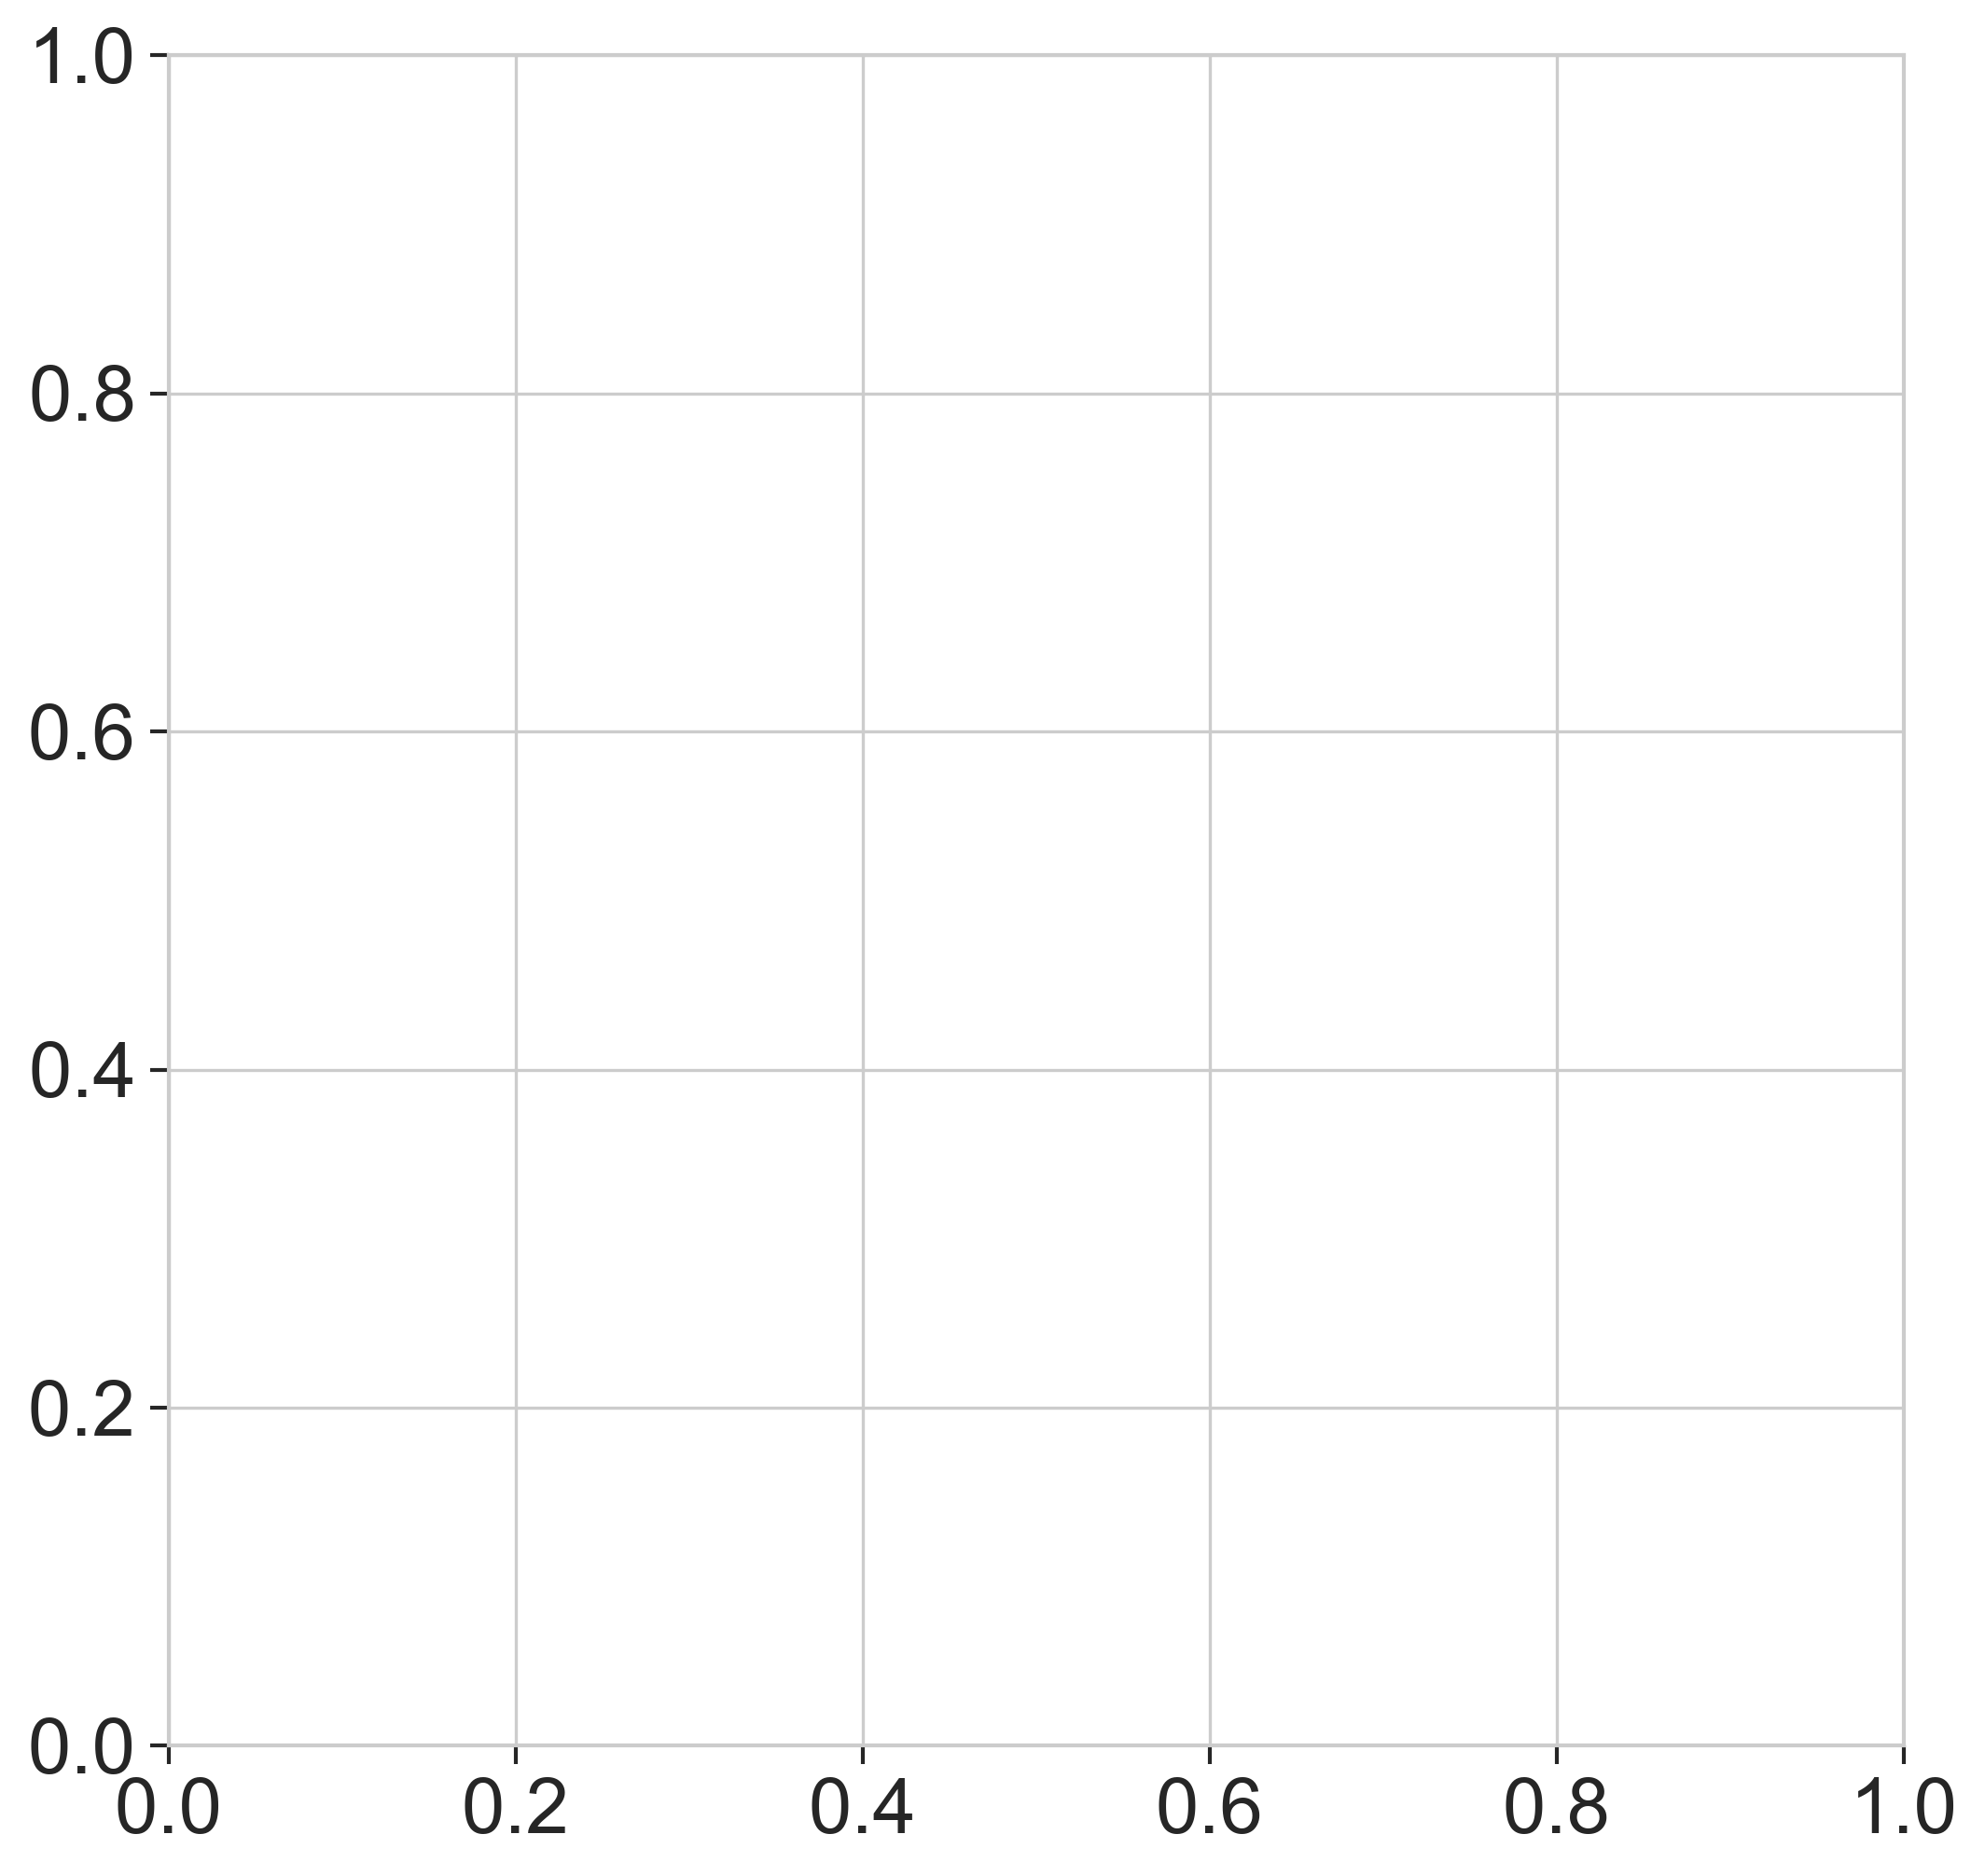

In [79]:
ms=10
mew=2

mc=pastels[0]
offset=.17
w=.5
ew=3

dark=darks[1]
pastel=pastels[1]



fig, ax=plt.subplots(figsize=(8,8), dpi=300)

sample=med.loc[(med['construct']=='-') & (med['sensor']=='506') & (med['DNA']=='-')]
ax.bar(0, sample['med'], width=w, color=pastel, edgecolor=dark, linewidth=ew)
ax.plot(0-offset, sample['med1'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(0, sample['med2'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(0+offset, sample['med3'], 'o', markersize=ms, color= dark, mew=mew, mec='black')

sample=med.loc[(med['construct']=='-') & (med['sensor']=='511') & (med['DNA']=='-')]
ax.bar(1, sample['med'], width=w, color=pastel, edgecolor=dark, linewidth=ew)
ax.plot(1-offset, sample['med1'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(1, sample['med2'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(1+offset, sample['med3'], 'o', markersize=ms, color= dark, mew=mew, mec='black')

sample=med.loc[(med['construct']=='746') & (med['sensor']=='506') & (med['DNA']=='-')]
ax.bar(2, sample['med'], width=w, color=pastel, edgecolor=dark, linewidth=ew)
ax.plot(2-offset, sample['med1'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(2, sample['med2'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(2+offset, sample['med3'], 'o', markersize=ms, color= dark, mew=mew, mec='black')

sample=med.loc[(med['construct']=='753') & (med['sensor']=='506') & (med['DNA']=='-')]
ax.bar(3, sample['med'], width=w, color=pastel, edgecolor=dark, linewidth=ew)
ax.plot(3-offset, sample['med1'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(3, sample['med2'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(3+offset, sample['med3'], 'o', markersize=ms, color= dark, mew=mew, mec='black')

sample=med.loc[(med['construct']=='755') & (med['sensor']=='506') & (med['DNA']=='-')]
ax.bar(4, sample['med'], width=w, color=pastel, edgecolor=dark, linewidth=ew)
ax.plot(4-offset, sample['med1'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(4, sample['med2'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(4+offset, sample['med3'], 'o', markersize=ms, color= dark, mew=mew, mec='black')

ax.grid(False)
ax.set_yscale('log')

ax.set_ylim(50, 100000)
ax.set_xticklabels([])
ax.set_xticks([0, 1, 2, 3, 4])

ax.tick_params(which='major', direction='out', length=15, width=4)
ax.tick_params(which='minor', direction='out', length=0, width=2)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(4)
    ax.spines[axis].set_color('black')
ax.tick_params(axis='both', which='major', labelsize=40)

plt.show()
plt.tight_layout()
# fig.savefig('dCas_spacers_rev.pdf', bbox_inches='tight')
plt.close()

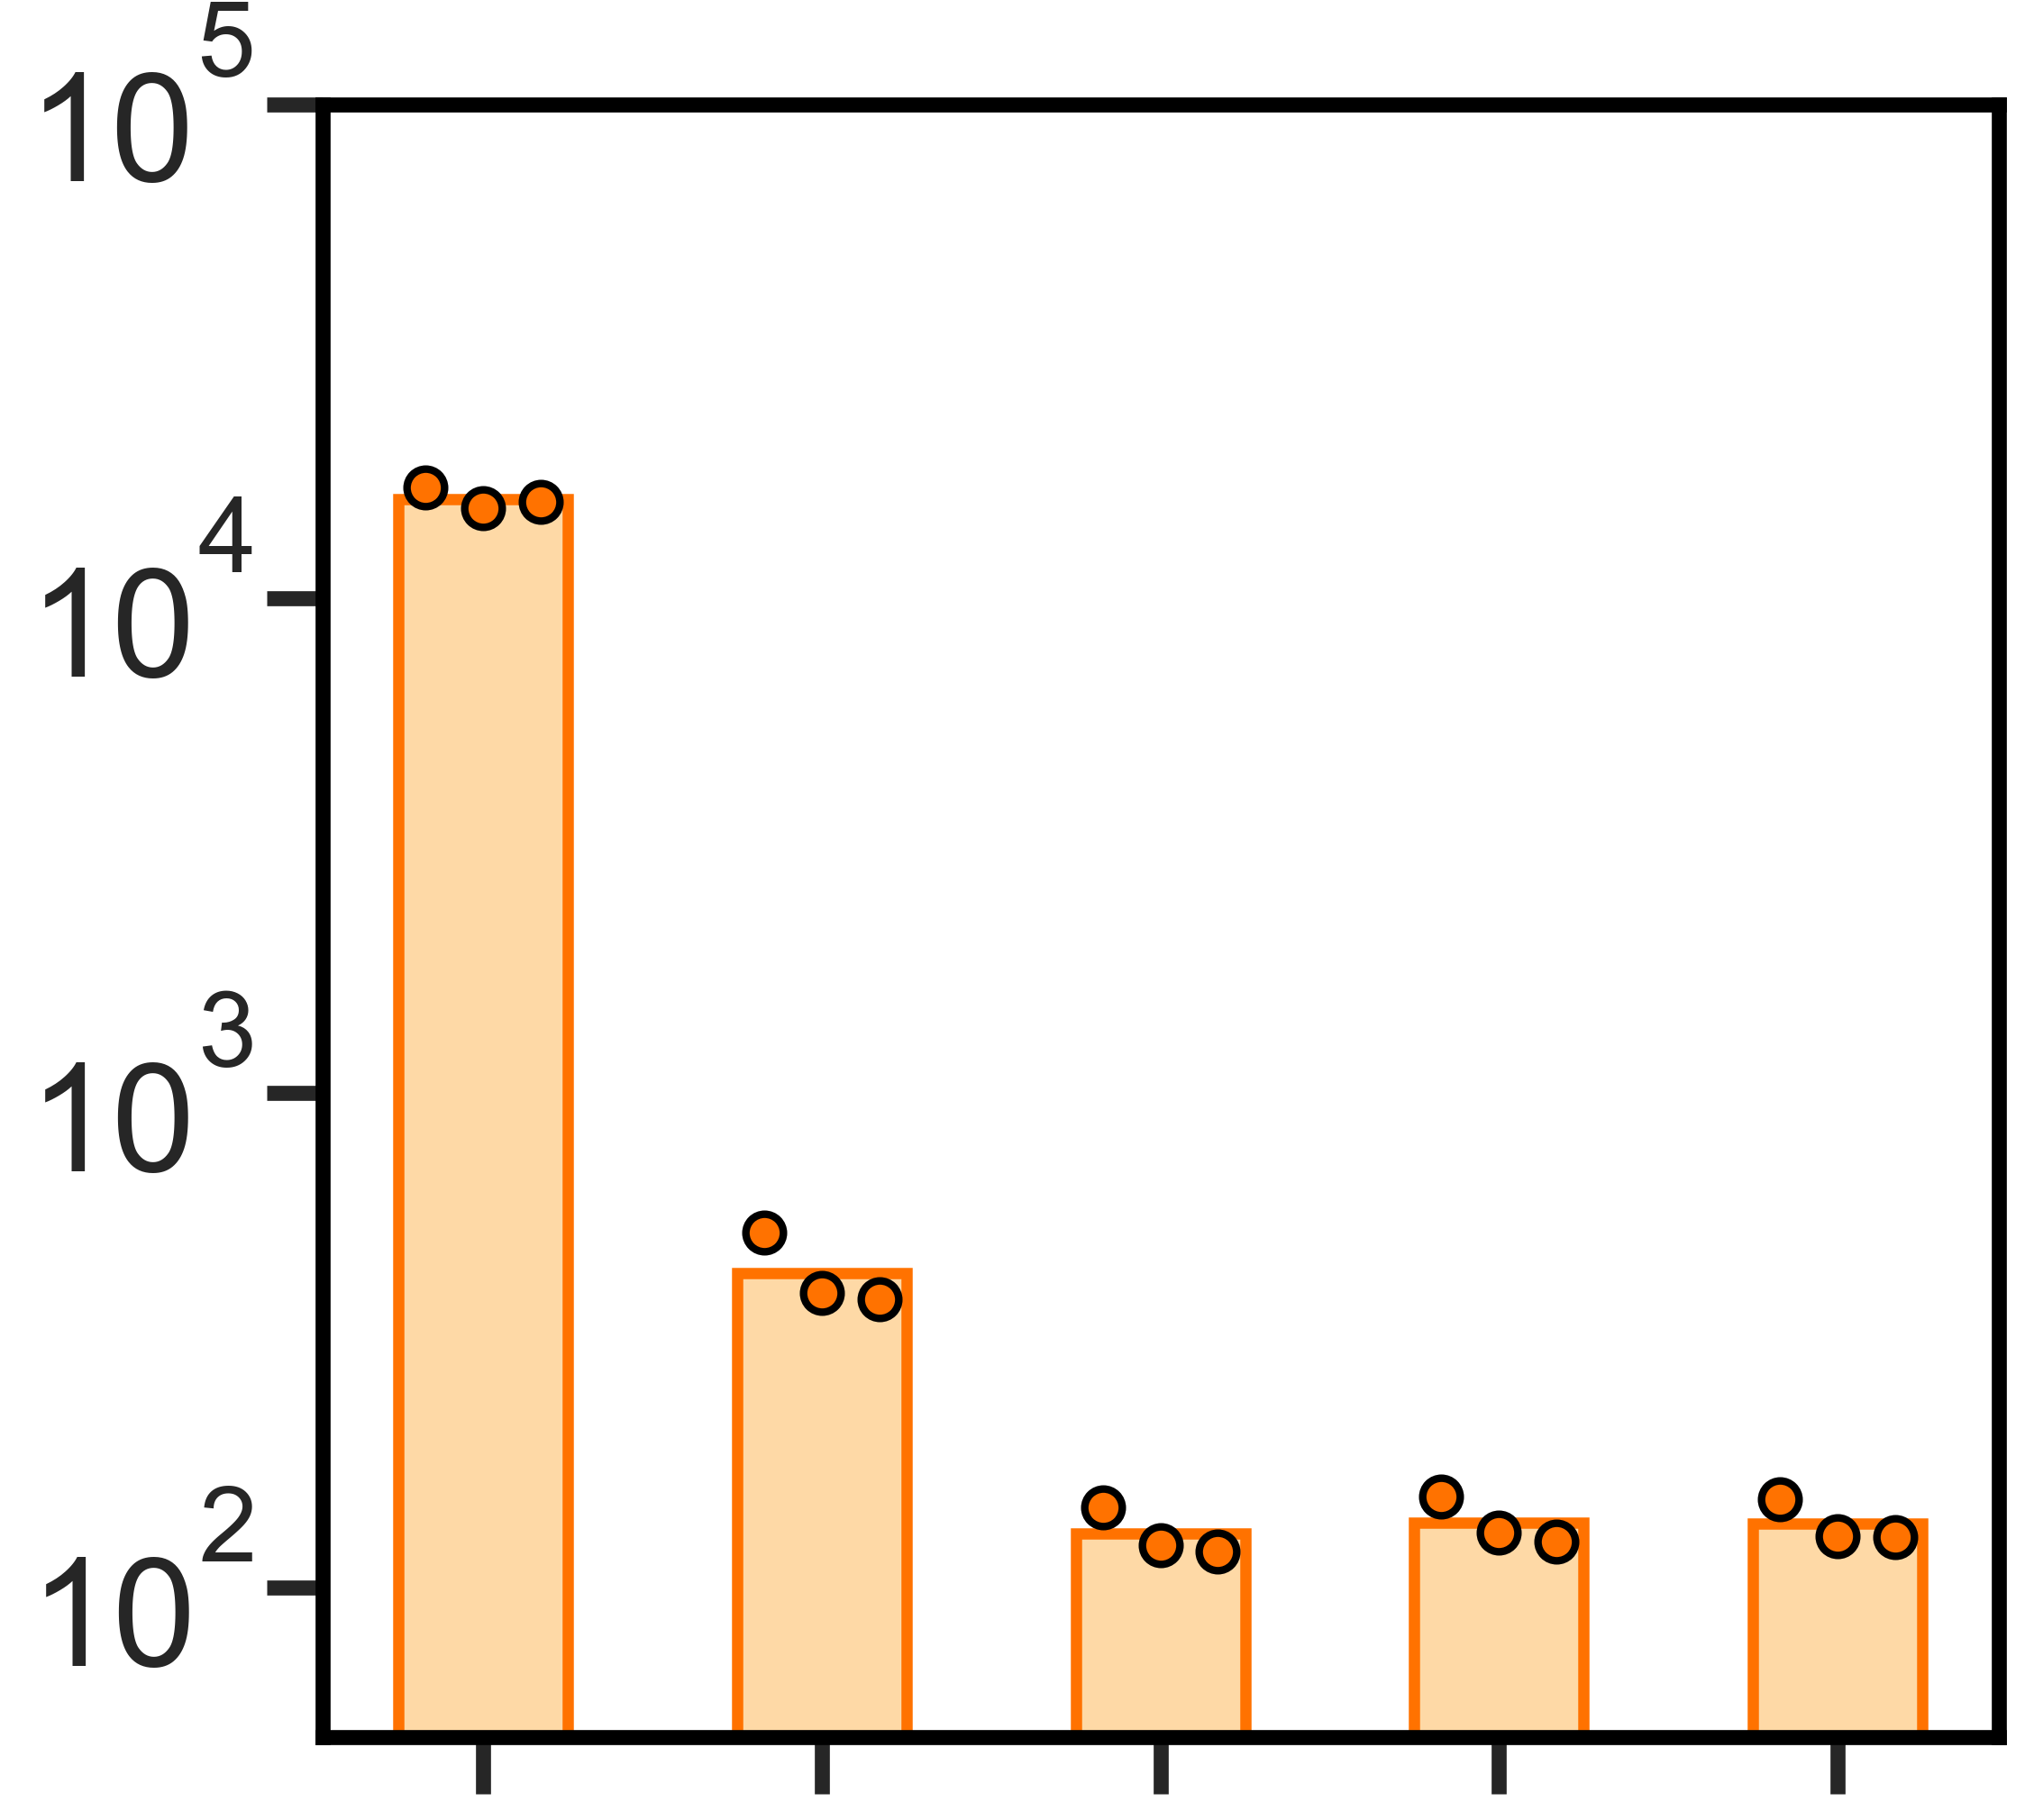

In [51]:
ms=10
mew=2

mc=pastels[0]
offset=.17
w=.5
ew=3

dark=darks[1]
pastel=pastels[1]



fig, ax=plt.subplots(figsize=(8,8), dpi=300)

sample=med.loc[(med['construct']=='-') & (med['sensor']=='506') & (med['DNA']=='-')]
ax.bar(0, sample['med'], width=w, color=pastel, edgecolor=dark, linewidth=ew)
ax.plot(0-offset, sample['med1'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(0, sample['med2'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(0+offset, sample['med3'], 'o', markersize=ms, color= dark, mew=mew, mec='black')

sample=med.loc[(med['construct']=='-') & (med['sensor']=='511') & (med['DNA']=='-')]
ax.bar(1, sample['med'], width=w, color=pastel, edgecolor=dark, linewidth=ew)
ax.plot(1-offset, sample['med1'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(1, sample['med2'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(1+offset, sample['med3'], 'o', markersize=ms, color= dark, mew=mew, mec='black')

sample=med.loc[(med['construct']=='744') & (med['sensor']=='506') & (med['DNA']=='-')]
ax.bar(2, sample['med'], width=w, color=pastel, edgecolor=dark, linewidth=ew)
ax.plot(2-offset, sample['med1'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(2, sample['med2'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(2+offset, sample['med3'], 'o', markersize=ms, color= dark, mew=mew, mec='black')

sample=med.loc[(med['construct']=='751') & (med['sensor']=='506') & (med['DNA']=='-')]
ax.bar(3, sample['med'], width=w, color=pastel, edgecolor=dark, linewidth=ew)
ax.plot(3-offset, sample['med1'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(3, sample['med2'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(3+offset, sample['med3'], 'o', markersize=ms, color= dark, mew=mew, mec='black')

sample=med.loc[(med['construct']=='752') & (med['sensor']=='506') & (med['DNA']=='-')]
ax.bar(4, sample['med'], width=w, color=pastel, edgecolor=dark, linewidth=ew)
ax.plot(4-offset, sample['med1'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(4, sample['med2'], 'o', markersize=ms, color= dark, mew=mew, mec='black')
ax.plot(4+offset, sample['med3'], 'o', markersize=ms, color= dark, mew=mew, mec='black')

ax.grid(False)
ax.set_yscale('log')

ax.set_ylim(50, 100000)
ax.set_xticklabels([])
ax.set_xticks([0, 1, 2, 3, 4])



ax.tick_params(which='major', direction='out', length=15, width=4)
ax.tick_params(which='minor', direction='out', length=0, width=2)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(4)
    ax.spines[axis].set_color('black')
ax.tick_params(axis='both', which='major', labelsize=40)

plt.show()
plt.tight_layout()
# fig.savefig('dCas_spacers_norm.pdf', bbox_inches='tight')
plt.close()